In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mitbit-arrhythmia-database/mitbih_database/112annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/233.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/118annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/231.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/207.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/115annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/108annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/123annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/102annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/209.csv
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/203annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/202annotations.txt
/kaggle/input/mitbit-arrhythmia-database/mitbih_database/215annotat

In [2]:
! pip install --upgrade seaborn

In [3]:
import pandas as pd 
import os

import matplotlib.pyplot as plt
import csv
import itertools
import collections

import pywt
from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential , Model
from keras.layers import Dense, LSTM, Dropout, Softmax, Bidirectional, Flatten
import math
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [4]:
from tensorflow.keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers

In [5]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [6]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 180
classes = ['N', 'A', 'V', 'F', 'f']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

In [7]:
filenames = next(os.walk(path))[2]
records = list()
annotations = list()
filenames.sort()

In [8]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

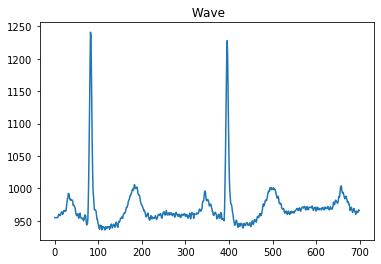

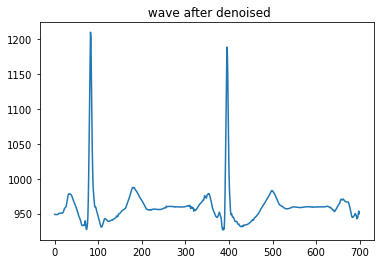

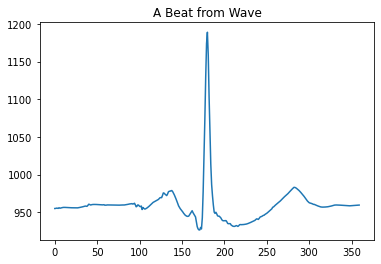

(86470, 360) (86470,)


In [9]:
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    if r is 1:
        plt.title(" Wave")
        plt.plot(signals[0:700])
        plt.show()
    signals = denoise(signals)
    if r is 1:
        plt.title(" wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()
        for d in range(1, len(data)): 
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted))
            arrhythmia_type = next(splitted)
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     
                    if r is 1 and not example_beat_printed: 
                        plt.title("A Beat from Wave")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True
                    X.append(beat)
                    y.append(arrhythmia_index)

print(np.shape(X), np.shape(y))

In [10]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
print(np.shape(X))

(86470, 361)


In [11]:
X_train_df = pd.DataFrame(X)
X_train_df

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,360
0,963.374455,963.536949,964.756621,965.399062,966.017086,966.375099,966.610054,966.770207,966.863751,966.951485,...,962.278640,962.282842,962.301737,962.395261,962.294270,961.799296,963.125729,961.823215,962.056695,0.0
1,950.134075,950.900959,951.742885,951.389255,952.444730,952.698845,952.985557,953.265506,953.554840,953.878155,...,957.912677,957.910661,957.908414,957.887200,957.930868,958.046497,957.767864,957.935546,957.848457,0.0
2,956.855367,957.921859,958.970263,960.062874,961.063537,961.544535,961.778225,961.903495,961.914781,961.927284,...,962.793234,963.018453,963.291927,963.610334,963.801834,963.664744,964.690013,963.714316,963.719371,0.0
3,956.333844,956.469719,956.650190,956.840204,957.063040,957.289795,957.532154,957.763758,957.903596,958.002126,...,963.483037,963.849264,964.232722,964.751295,965.325454,965.385283,965.277388,965.949119,966.749783,0.0
4,950.051087,950.080657,950.899845,951.943309,952.584266,953.144752,953.758744,954.385010,955.116512,955.847917,...,962.082603,962.257165,962.430031,962.608560,962.787336,962.969444,963.152923,963.315874,963.472298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86465,960.091597,958.332371,959.228982,959.937280,960.462593,960.875403,961.311190,961.743369,962.152282,962.574638,...,964.516509,965.081464,965.657630,965.508808,965.080290,964.863438,964.607543,964.151499,963.933098,0.0
86466,960.158109,960.774672,961.122588,962.403698,963.542825,966.482368,966.960323,967.707577,968.022530,968.521270,...,963.553957,962.929216,962.408595,961.909285,961.207912,960.546289,959.842670,959.283797,959.529191,0.0
86467,959.520187,958.437111,959.105015,959.603769,960.050059,961.738668,962.600041,960.552121,957.583658,959.426743,...,968.586538,969.176431,969.713374,970.199836,970.198314,970.071392,969.631823,969.133521,969.677513,0.0
86468,957.960255,957.948389,959.213426,959.568639,959.893190,960.498387,961.169668,961.611360,961.984491,962.369367,...,974.808446,973.751860,972.810871,971.849649,970.724459,969.718156,968.525272,967.561324,968.065026,0.0


In [12]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    75011
2.0     7129
1.0     2546
4.0      982
3.0      802
Name: 360, dtype: int64


In [13]:
df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]
df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=42)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=42)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=42)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=42)
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [14]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)

0.0    5000
1.0    5000
2.0    5000
3.0    5000
4.0    5000
Name: 360, dtype: int64


In [15]:
train, test = train_test_split(X_train_df, test_size=0.20)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (20000, 361)
X_test  :  (5000, 361)


In [16]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(20000, 5) (5000, 5)


In [17]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(20000, 360, 1) (5000, 360, 1)


In [18]:
print(train_x)

[[[ 843.43366447]
  [ 843.24219853]
  [ 843.3842278 ]
  ...
  [ 848.3646991 ]
  [ 849.2542797 ]
  [ 848.02979254]]

 [[ 997.57716518]
  [ 996.5617298 ]
  [ 992.58734927]
  ...
  [ 992.00007444]
  [ 992.81284499]
  [ 994.04644401]]

 [[1006.30136421]
  [1006.45254063]
  [1006.60897163]
  ...
  [1044.19126377]
  [1041.33774063]
  [1038.56444843]]

 ...

 [[ 966.38346538]
  [ 966.63188041]
  [ 967.233652  ]
  ...
  [1217.66795625]
  [1209.70755542]
  [1201.97454127]]

 [[ 949.2547293 ]
  [ 950.17663217]
  [ 951.12302364]
  ...
  [ 981.61737939]
  [ 981.53657879]
  [ 981.44459003]]

 [[ 800.24672441]
  [ 818.29926335]
  [ 843.39757487]
  ...
  [ 805.05676997]
  [ 804.55755483]
  [ 805.07834096]]]


In [19]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(units=50, return_sequences=True, activation='tanh', input_shape=(360,1))))
model1.add(Bidirectional(LSTM(units=10, return_sequences=True, activation='tanh')))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(35))
model1.add(Dense(5))
model1.add(Softmax())

2022-06-20 10:30:20.566571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 10:30:20.714726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 10:30:20.715533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-20 10:30:20.716846: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model1.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [21]:
history  = model1.fit(train_x, train_y, batch_size=128, epochs=60, verbose=1, validation_data=(test_x, test_y))

2022-06-20 10:30:23.548414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/60


2022-06-20 10:30:29.369863: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


157/157 [==============================] - 21s 89ms/step - loss: 1.7376 - accuracy: 0.1975 - val_loss: 1.6164 - val_accuracy: 0.1982
Epoch 2/60
157/157 [==============================] - 13s 80ms/step - loss: 1.6111 - accuracy: 0.2004 - val_loss: 1.6105 - val_accuracy: 0.1996
Epoch 3/60
157/157 [==============================] - 13s 80ms/step - loss: 1.6106 - accuracy: 0.1986 - val_loss: 1.6095 - val_accuracy: 0.1982
Epoch 4/60
157/157 [==============================] - 12s 79ms/step - loss: 1.6102 - accuracy: 0.1972 - val_loss: 1.6141 - val_accuracy: 0.1996
Epoch 5/60
157/157 [==============================] - 13s 80ms/step - loss: 1.6138 - accuracy: 0.2007 - val_loss: 1.6105 - val_accuracy: 0.2086
Epoch 6/60
157/157 [==============================] - 12s 78ms/step - loss: 1.6081 - accuracy: 0.2138 - val_loss: 1.6494 - val_accuracy: 0.1974
Epoch 7/60
157/157 [==============================] - 12s 79ms/step - loss: 1.5848 - accuracy: 0.2538 - val_loss: 1.5710 - val_accuracy: 0.1988
Epo

In [22]:
score1 = model1.evaluate(test_x, test_y)
print(score1[1])

157/157 [==============================] - 4s 28ms/step - loss: 0.2638 - accuracy: 0.9156
0.9156000018119812


In [23]:
def speci(kcm):
    total=sum(sum(kcm))
    sensitivity1 = kcm[0,0]/(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4])
    print('Sensitivity of  Non-ecotic beats (normal beat) ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[0,0]+kcm[0,1]+kcm[0,2]+kcm[0,3]+kcm[0,4]))
    print('Specificity of  Non-ecotic beats (normal beat) ', specificity1)
    sensitivity1 = kcm[1,1]/(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4])
    print('Sensitivity of  Supraventricular ectopic beats ', sensitivity1 )
    specificity1 = (kcm[0,0]+kcm[2,2]+kcm[3,3]+kcm[4,4])/(total-(kcm[1,0]+kcm[1,1]+kcm[1,2]+kcm[1,3]+kcm[1,4]))
    print('Specificity of  Supraventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[2,2]/(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4])
    print('Sensitivity of  Ventricular ectopic beats  ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[0,0]+kcm[3,3]+kcm[4,4])/(total-(kcm[2,0]+kcm[2,1]+kcm[2,2]+kcm[2,3]+kcm[2,4]))
    print('Specificity of  Ventricular ectopic beats ', specificity1)
    sensitivity1 = kcm[3,3]/(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4])
    print('Sensitivity of  Fusion Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[0,0]+kcm[4,4])/(total-(kcm[3,0]+kcm[3,1]+kcm[3,2]+kcm[3,3]+kcm[3,4]))
    print('Specificity of  Fusion Beats ', specificity1)
    sensitivity1 = kcm[4,4]/(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4])
    print('Sensitivity of  Unknown Beats ', sensitivity1 )
    specificity1 = (kcm[1,1]+kcm[2,2]+kcm[3,3]+kcm[0,0])/(total-(kcm[4,0]+kcm[4,1]+kcm[4,2]+kcm[4,3]+kcm[4,4]))
    print('Specificity of  Unknown Beats ', specificity1)
    

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model1.predict(test_x)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(test_y,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
print(confusion_mtx)
print(classification_report(Y_true, Y_pred_classes))
speci(confusion_mtx)

[[897  28  18  67  33]
 [104 862   7   4  21]
 [ 13  17 916  36   6]
 [ 20   6  30 917   7]
 [  2   0   3   0 986]]
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1043
           1       0.94      0.86      0.90       998
           2       0.94      0.93      0.93       988
           3       0.90      0.94      0.92       980
           4       0.94      0.99      0.96       991

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.92      0.92      0.92      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8600191754554171
Specificity of  Non-ecotic beats (normal beat)  0.9302501895375285
Sensitivity of  Supraventricular ectopic beats  0.8637274549098196
Specificity of  Supraventricular ectopic beats  0.928535732133933
Sensitivity of  Ventricular ectopic beats   0.9271255060728745
Specificity of  Ventricular ectopic beats  0.9127617148554337
Sen

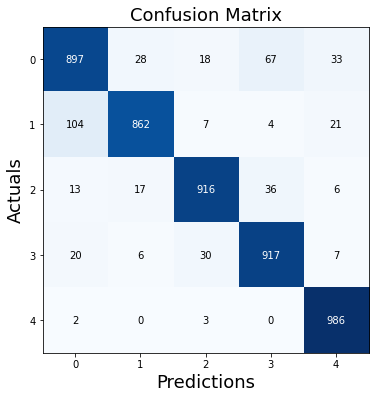

In [25]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=confusion_mtx, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [26]:
model_feat = Model(inputs=model1.input,outputs=model1.get_layer('flatten').output)
feat_train = model_feat.predict(train_x)
print(feat_train.shape)
feat_test = model_feat.predict(test_x)
print(feat_test.shape)

(20000, 7200)
(5000, 7200)


In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import time
start0 = time.time()
sc = StandardScaler()
X_train = sc.fit_transform(feat_train)
X_test = sc.transform(feat_test)
pca = PCA(n_components = 150)
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_test)
stop0 = time.time()
print(f"Time: {stop0 - start0}s")

Time: 11.203355312347412s


In [28]:
print(pca_X_train.shape)
print(pca_X_test.shape)

(20000, 150)
(5000, 150)


In [29]:
import time

In [30]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')
t0=time.time()
svm.fit(pca_X_train,np.argmax(train_y,axis=1))
t1=time.time()
print(f"Training time: {t1-t0}s")

Training time: 18.13124942779541s


In [31]:
t2=time.time()
Pred_labels = svm.predict(pca_X_test)
t3=time.time()
print(Pred_labels )
print(f"Testing time: {t3-t1}s")

[0 0 2 ... 3 3 1]
Testing time: 11.810647010803223s


In [32]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,Pred_labels)
print("Accuracy:",accuracy)

Accuracy: 0.9564


In [33]:
cm = confusion_matrix(target_test, Pred_labels) 
print(cm)
print(classification_report(target_test, Pred_labels))
speci(cm)

[[986  18  13  21   5]
 [ 82 905   6   1   4]
 [  7   6 965   9   1]
 [ 29   0   9 937   5]
 [  2   0   0   0 989]]
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92      1043
         1.0       0.97      0.91      0.94       998
         2.0       0.97      0.98      0.97       988
         3.0       0.97      0.96      0.96       980
         4.0       0.99      1.00      0.99       991

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9453499520613614
Specificity of  Non-ecotic beats (normal beat)  0.9593126105635582
Sensitivity of  Supraventricular ectopic beats  0.906813627254509
Specificity of  Supraventricular ectopic beats  0.9687656171914043
Sensitivity of  Ventricular ectopic beats   0.9767206477732794
Specificity of  Ventricular ectopic beats  0.9513958125623131
Sen

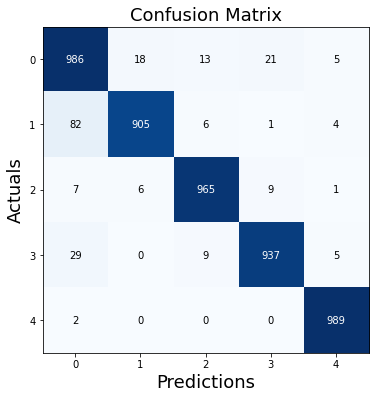

In [34]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [35]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
t4=time.time()
knn.fit(pca_X_train,np.argmax(train_y,axis=1))
t5=time.time()
print(f"Training time: {t5-t4}s")

Training time: 1.1047019958496094s


In [36]:
t6=time.time()
knn_labels = knn.predict(pca_X_test)
t7=time.time()
print(knn_labels )
print(f"Testing time: {t7-t6}s")

[0 0 4 ... 3 3 1]
Testing time: 7.635823488235474s


In [37]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,knn_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, knn_labels) 
print(cm)
print(classification_report(target_test, knn_labels))
speci(cm)

Accuracy: 0.9668
[[972  26   7  22  16]
 [ 23 970   4   1   0]
 [ 17  11 937  20   3]
 [  7   5   3 965   0]
 [  1   0   0   0 990]]
              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1043
         1.0       0.96      0.97      0.97       998
         2.0       0.99      0.95      0.97       988
         3.0       0.96      0.98      0.97       980
         4.0       0.98      1.00      0.99       991

    accuracy                           0.97      5000
   macro avg       0.97      0.97      0.97      5000
weighted avg       0.97      0.97      0.97      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9319271332694151
Specificity of  Non-ecotic beats (normal beat)  0.9759919130654536
Sensitivity of  Supraventricular ectopic beats  0.9719438877755511
Specificity of  Supraventricular ectopic beats  0.9655172413793104
Sensitivity of  Ventricular ectopic beats   0.9483805668016194
Specificity of  Ventricular ectopic beats  0.97

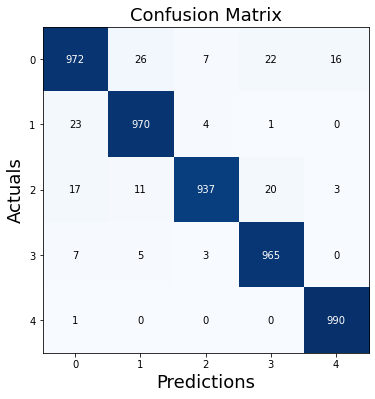

In [38]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [39]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='sigmoid')
t8=time.time()
svclassifier.fit(pca_X_train,np.argmax(train_y,axis=1))
t9=time.time()
print(f"Training time: {t9-t8}s")

Training time: 25.057815313339233s


In [40]:
t10=time.time()
svm_labels = svclassifier.predict(pca_X_test)
t11=time.time()
print(svm_labels )
print(f"Testing time: {t11-t10}s")

[0 0 2 ... 3 3 1]
Testing time: 7.694692850112915s


In [41]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.7712
[[715 119 133  61  15]
 [134 784  58  10  12]
 [141  61 675 106   5]
 [ 98  21 118 736   7]
 [ 14   2  29   0 946]]
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      1043
         1.0       0.79      0.79      0.79       998
         2.0       0.67      0.68      0.67       988
         3.0       0.81      0.75      0.78       980
         4.0       0.96      0.95      0.96       991

    accuracy                           0.77      5000
   macro avg       0.78      0.77      0.77      5000
weighted avg       0.77      0.77      0.77      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.6855225311601151
Specificity of  Non-ecotic beats (normal beat)  0.7937831690674754
Sensitivity of  Supraventricular ectopic beats  0.7855711422845691
Specificity of  Supraventricular ectopic beats  0.767616191904048
Sensitivity of  Ventricular ectopic beats   0.6831983805668016
Specificity of  Ventricular ectopic beats  0.792

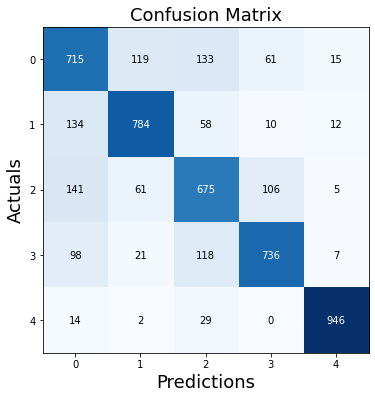

In [42]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [43]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='poly', degree=8)
t12=time.time()
svclassifier.fit(pca_X_train,np.argmax(train_y,axis=1))
t13=time.time()
print(f"Training time: {t13-t12}s")

Training time: 71.61512684822083s


In [44]:
t14=time.time()
svm_labels = svclassifier.predict(pca_X_test)
t15=time.time()
print(svm_labels )
print(f"Testing time: {t15-t14}s")

[4 4 4 ... 4 3 4]
Testing time: 12.301457405090332s


In [45]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,svm_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, svm_labels) 
print(cm)
print(classification_report(target_test, svm_labels))
speci(cm)

Accuracy: 0.618
[[292   8   1   4 738]
 [  2 277   0   0 719]
 [  0   3 765   5 215]
 [  3   1   0 765 211]
 [  0   0   0   0 991]]
              precision    recall  f1-score   support

         0.0       0.98      0.28      0.44      1043
         1.0       0.96      0.28      0.43       998
         2.0       1.00      0.77      0.87       988
         3.0       0.99      0.78      0.87       980
         4.0       0.34      1.00      0.51       991

    accuracy                           0.62      5000
   macro avg       0.85      0.62      0.62      5000
weighted avg       0.86      0.62      0.62      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.2799616490891659
Specificity of  Non-ecotic beats (normal beat)  0.7071013393985343
Sensitivity of  Supraventricular ectopic beats  0.2775551102204409
Specificity of  Supraventricular ectopic beats  0.7028985507246377
Sensitivity of  Ventricular ectopic beats   0.7742914979757085
Specificity of  Ventricular ectopic beats  0.579

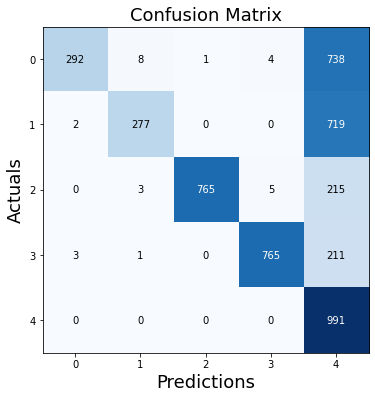

In [46]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [47]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
t16=time.time()
gnb.fit(pca_X_train,np.argmax(train_y,axis=1))
t17=time.time()
print(f"Training time: {t17-t16}s")

Training time: 0.021541357040405273s


In [48]:
t18=time.time()
gnb_labels = gnb.predict(pca_X_test)
t19=time.time()
print(gnb_labels )
print(f"Testing time: {t19-t18}s")

[4 0 4 ... 4 3 0]
Testing time: 0.015908002853393555s


In [49]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,gnb_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, gnb_labels) 
print(cm)
print(classification_report(target_test, gnb_labels))
speci(cm)

Accuracy: 0.5836
[[650  22  97  26 248]
 [532  86 214   5 161]
 [ 87  49 590 238  24]
 [ 91   0 110 723  56]
 [  0  26  72  24 869]]
              precision    recall  f1-score   support

         0.0       0.48      0.62      0.54      1043
         1.0       0.47      0.09      0.15       998
         2.0       0.54      0.60      0.57       988
         3.0       0.71      0.74      0.72       980
         4.0       0.64      0.88      0.74       991

    accuracy                           0.58      5000
   macro avg       0.57      0.58      0.54      5000
weighted avg       0.57      0.58      0.54      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.62320230105465
Specificity of  Non-ecotic beats (normal beat)  0.5731614859742229
Sensitivity of  Supraventricular ectopic beats  0.08617234468937876
Specificity of  Supraventricular ectopic beats  0.7076461769115442
Sensitivity of  Ventricular ectopic beats   0.597165991902834
Specificity of  Ventricular ectopic beats  0.5802

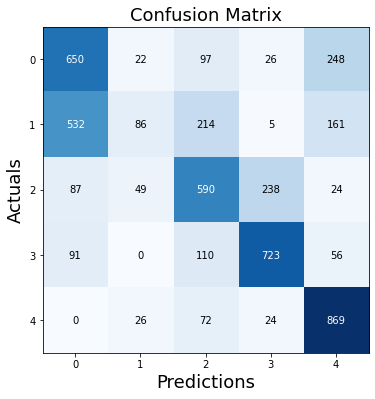

In [50]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
t20=time.time()
dt.fit(pca_X_train,np.argmax(train_y,axis=1))
t21=time.time()
print(f"Training time: {t21-t20}s")

Training time: 4.460506439208984s


In [52]:
t22=time.time()
dt_labels = dt.predict(pca_X_test)
t23=time.time()
print(dt_labels )
print(f"Testing time: {t23-t22}s")

[0 0 2 ... 3 3 1]
Testing time: 0.0022029876708984375s


In [53]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,dt_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, dt_labels) 
print(cm)
print(classification_report(target_test, dt_labels))
speci(cm)

Accuracy: 0.9544
[[912  57  31  24  19]
 [ 22 966   5   2   3]
 [ 28  13 930  13   4]
 [  0   0   6 974   0]
 [  0   0   0   1 990]]
              precision    recall  f1-score   support

         0.0       0.95      0.87      0.91      1043
         1.0       0.93      0.97      0.95       998
         2.0       0.96      0.94      0.95       988
         3.0       0.96      0.99      0.98       980
         4.0       0.97      1.00      0.99       991

    accuracy                           0.95      5000
   macro avg       0.95      0.96      0.95      5000
weighted avg       0.95      0.95      0.95      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.8744007670182167
Specificity of  Non-ecotic beats (normal beat)  0.9754864796563053
Sensitivity of  Supraventricular ectopic beats  0.9679358717434869
Specificity of  Supraventricular ectopic beats  0.9510244877561219
Sensitivity of  Ventricular ectopic beats   0.9412955465587044
Specificity of  Ventricular ectopic beats  0.95

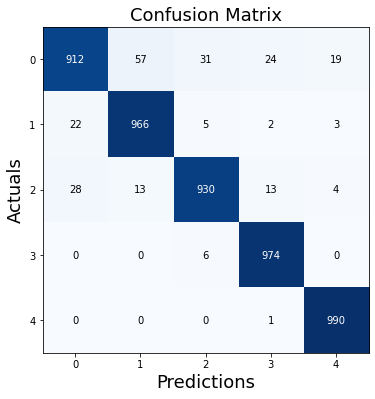

In [54]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [55]:
from sklearn.ensemble import RandomForestClassifier
rfc= RandomForestClassifier()
t24=time.time()
rfc.fit(pca_X_train,np.argmax(train_y,axis=1))
t25=time.time()
print(f"Training time: {t25-t24}s")

Training time: 18.850601196289062s


In [56]:
t26=time.time()
rfc_labels = rfc.predict(pca_X_test)
t27=time.time()
print(rfc_labels )
print(f"Testing time: {t27-t26}s")

[0 0 2 ... 3 3 1]
Testing time: 0.08942484855651855s


In [57]:
from sklearn import metrics
accuracy = metrics.accuracy_score(target_test ,rfc_labels)
print("Accuracy:",accuracy)
cm = confusion_matrix(target_test, rfc_labels) 
print(cm)
print(classification_report(target_test, rfc_labels))
speci(cm)

Accuracy: 0.9832
[[995  16  18  11   3]
 [ 16 979   3   0   0]
 [  9   2 974   2   1]
 [  0   0   3 977   0]
 [  0   0   0   0 991]]
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96      1043
         1.0       0.98      0.98      0.98       998
         2.0       0.98      0.99      0.98       988
         3.0       0.99      1.00      0.99       980
         4.0       1.00      1.00      1.00       991

    accuracy                           0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Sensitivity of  Non-ecotic beats (normal beat)  0.9539789069990412
Specificity of  Non-ecotic beats (normal beat)  0.9909021986353298
Sensitivity of  Supraventricular ectopic beats  0.9809619238476954
Specificity of  Supraventricular ectopic beats  0.9837581209395302
Sensitivity of  Ventricular ectopic beats   0.9858299595141701
Specificity of  Ventricular ectopic beats  0.98

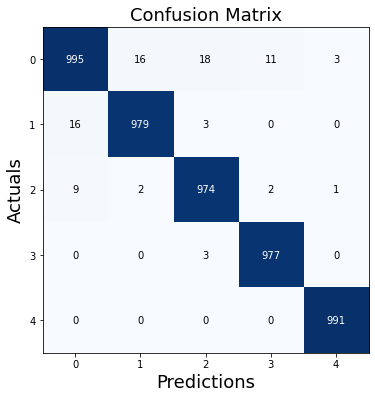

In [58]:
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm, figsize=(6, 6), cmap=plt.cm.Blues)
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [59]:
target= X_train_df[X_train_df.shape[1]-1]
feature = X_train_df.iloc[:,:X_train_df.shape[1]-1].values
feature = feature.reshape(len(feature), feature.shape[1],1)

In [60]:
feat = model_feat.predict(feature)
X_train = sc.fit_transform(feat)
pca = PCA(n_components = 150)
pca_train = pca.fit_transform(X_train)
print(pca_train.shape)
from sklearn.model_selection import cross_val_score
score = cross_val_score(rfc, pca_train, target, scoring='accuracy', cv=10)
print(score)

(25000, 150)
[0.9836 0.9836 0.9812 0.9812 0.982  0.9816 0.9872 0.9836 0.9864 0.9804]


In [61]:
print("Avg :",np.average(score))

Avg : 0.98308
